# Mixture Density Networks

A mixture density network is a probabilistic model of the form

$$
    p({\bf t}|{\bf x}) = \sum_{k=1}^K \pi_k({\bf x})\mathcal{N}({\bf t}, {\boldsymbol \mu}_k({\bf x}), {\bf I}\sigma_k^2)
$$

Where the coefficients in the model, namely $\{\pi_k({\bf x})\}_k$, $\{{\boldsymbol \mu}_k({\bf x})\}_k$, and $\{\sigma_k({\bf x})\}_k$ are modelled as the outputs of a feedforward neural nework.

A mixture density network is of use whenever we are presented with multimodal or nongauassian data

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed, normal, uniform, randn
from sklearn.neural_network import MLPRegressor

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
seed(2718)
nsamples = 100
xn = uniform(low=0, high=1, size=nsamples)
noise = uniform(low=-0.1, high=0.1, size=nsamples)
tn = xn + 0.3 * np.sin(2 * np.pi * xn) + noise

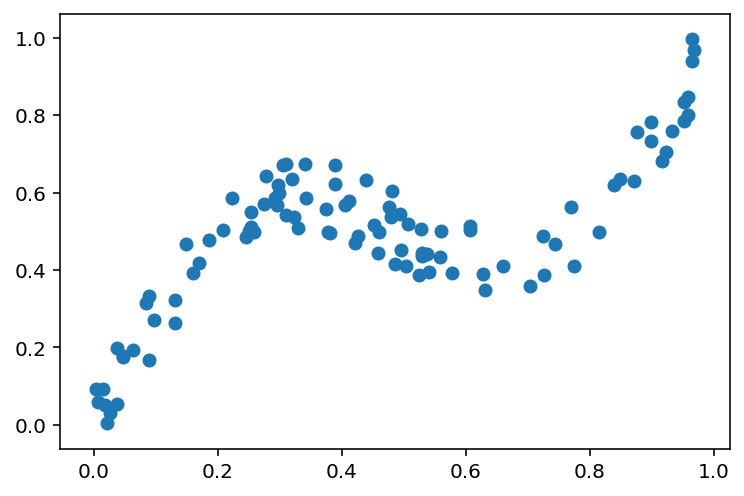

In [6]:
plt.scatter(xn, tn)

## The forward and inverse problems

In [7]:
xrange = np.linspace(0, 1, 100)

In [8]:
nn_forward = MLPRegressor(hidden_layer_sizes=(6, 6),
                  activation="tanh",
                  learning_rate_init=0.1,
                  solver="lbfgs", random_state=314)
nn_forward.fit(xn.reshape(-1, 1), tn)
yn_forward = nn_forward.predict(xrange.reshape(-1, 1))

In [9]:
nn_inverse = MLPRegressor(hidden_layer_sizes=(6, 6),
                  activation="tanh", 
                  learning_rate_init=0.1, tol=1e-6,
                  solver="lbfgs", random_state=3141)

nn_inverse.fit(tn.reshape(-1, 1), xn)
yn_inverse = nn_inverse.predict(xrange.reshape(-1, 1))

In [10]:
[c.shape for c in nn_forward.coefs_]

[(1, 6), (6, 6), (6, 1)]

In [11]:
[c.shape for c in nn_forward.intercepts_]

[(6,), (6,), (1,)]

In [12]:
print(f"Loss for the forward problem: {nn_forward.loss_:0.4f}")
print(f"Loss for the inverse problem: {nn_inverse.loss_:0.4f}")

Loss for the forward problem: 0.0017
Loss for the inverse problem: 0.0143


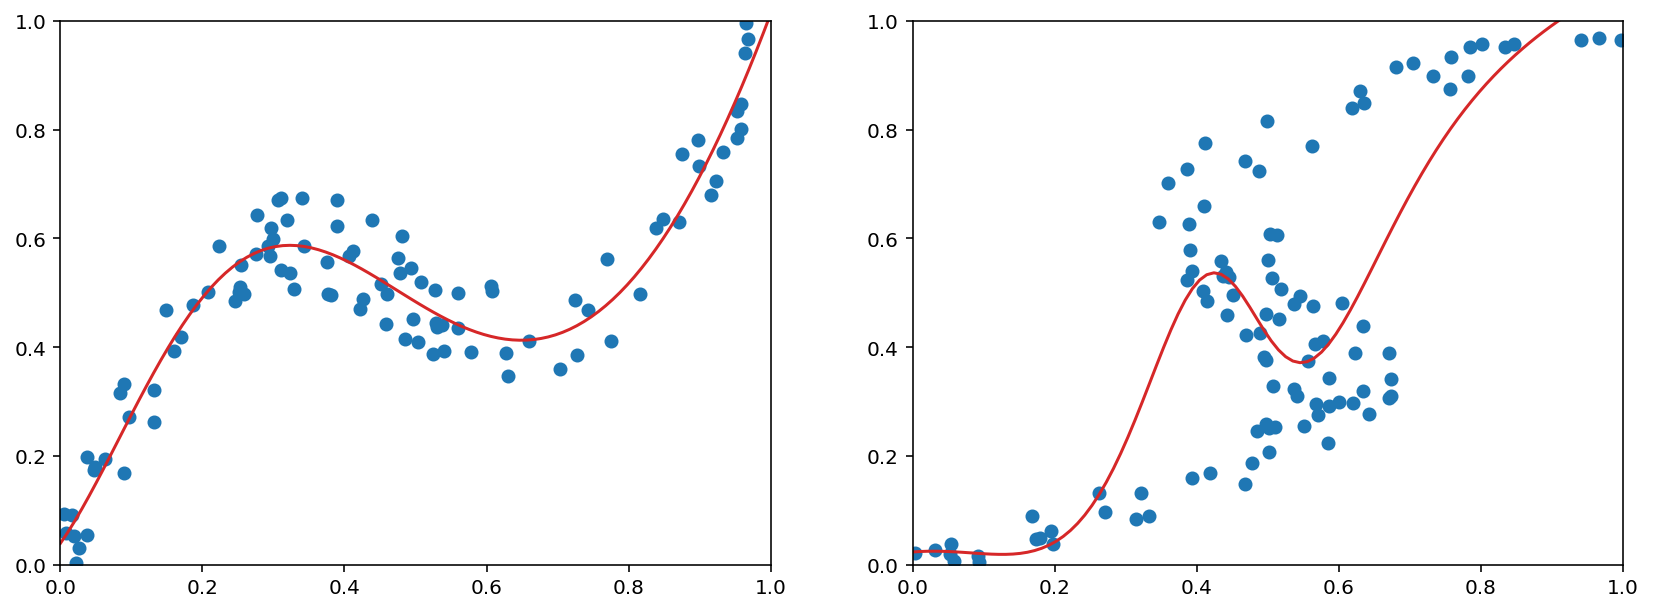

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(xn, tn)
ax[0].plot(xrange, yn_forward, c="tab:red")

ax[1].scatter(tn, xn)
ax[1].plot(xrange, yn_inverse, c="tab:red")

for axi in ax:
    axi.set_xlim(0, 1)
    axi.set_ylim(0, 1)

Choosing a least squares error function corresponds to a maximum likelihood under a Gaussian assumption. If the distribution of the parameters to fit is highly non-gaussian, the model cannot caputre the nature of the data.

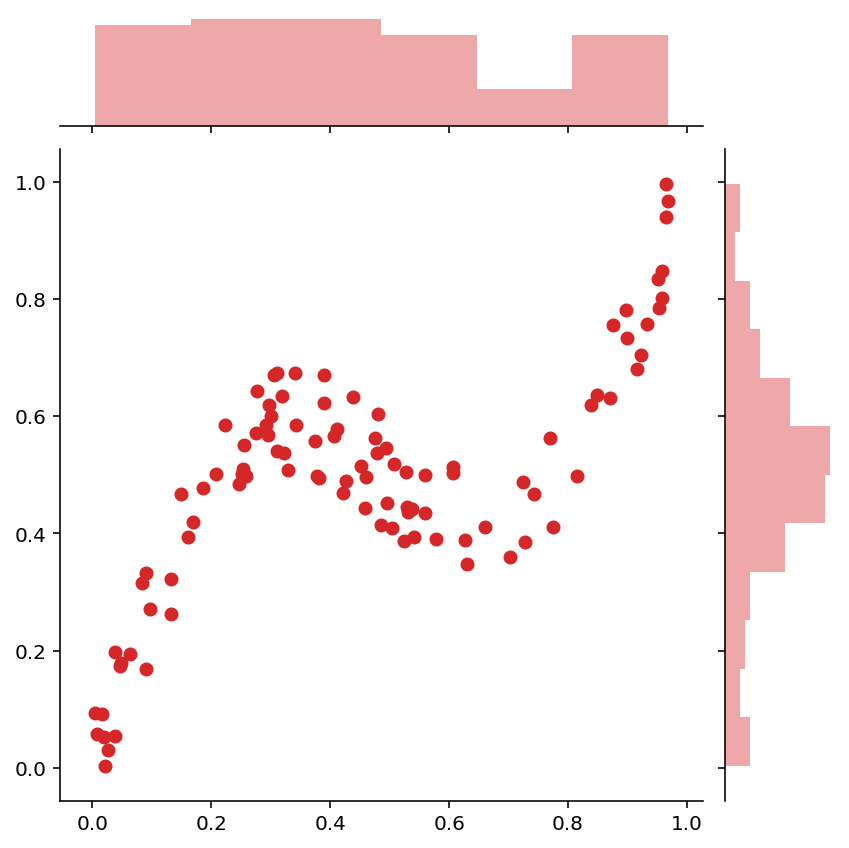

In [14]:
sns.jointplot(xn, tn, color="tab:red")

## Model Retraining

Before training the mixture density network, we begin by re-training the network using numpy and scipy so that we may debug and train the mixture using central diferences and L-BFGS

In [15]:
from scipy.optimize import minimize

In [16]:
seed(314)
w = normal(size=1 * 6 + 6 * 6 + 6 * 1 + 6 + 6 + 1)
w = np.clip(w, -1, 1)

In [17]:
def fforward(W, X):
    """
    A two-layered feed-forward activation function with "n" units
    at each hidden layer; one input unit; and one output unit
    """
    # weights
    w1 = W[:6].reshape(1, 6)
    w2 = W[6: 36 + 6].reshape(6, 6)
    w3 = W[42: 42 + 6].reshape(6, 1)
    # Biases
    wb1 = W[48:48 + 6]
    wb2 = W[54: 54 + 6]
    wb3 = W[60:]

    return np.tanh(np.tanh(X @ w1 + wb1) @ w2 + wb2) @ w3 + wb3

def nntrain(w, X, y):
    t = fforward(w, X).ravel()
    err2 = np.mean((t - y) ** 2) 
    return err2

### Central Differences Approximation

In [18]:
X = xn.reshape(-1, 1)

In [19]:
%%time
w0 = w.copy()
eps = 0.01
alpha = 0.5
epochs = 1_500
perturb = np.identity(w0.shape[0]) * eps

for _ in range(epochs):
    for ix, p in enumerate(perturb):
        w0[ix] = w0[ix] - alpha * (nntrain(w0 + p, X, tn) - nntrain(w0 - p, X, tn)) / (2 * eps)

CPU times: user 7.42 s, sys: 35.6 ms, total: 7.45 s
Wall time: 7.49 s


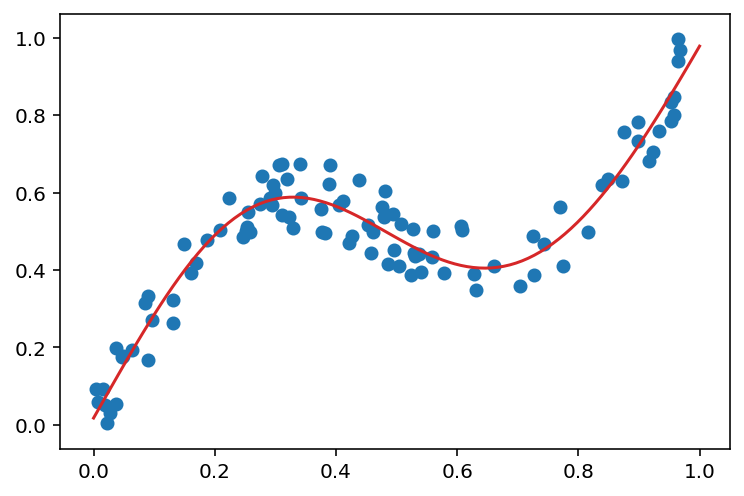

In [20]:
plt.scatter(X, tn)
plt.plot(xrange, fforward(w0, xrange.reshape(-1, 1)), c="tab:red")

### With L-BFGS

In [21]:
%%time
nnw = minimize(nntrain, w, (X, tn), method="l-bfgs-b",
               tol=1e-20)
nnw

CPU times: user 699 ms, sys: 5.6 ms, total: 704 ms
Wall time: 707 ms


      fun: 0.00327825121316806
 hess_inv: <61x61 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.69403683e-04,  7.40553452e-07,  1.26964758e-04, -6.83654522e-07,
        7.25035483e-05, -2.90678766e-04, -2.29117289e-04,  6.87817858e-08,
        1.85181731e-08, -2.16840434e-09,  2.54739806e-06, -2.33593526e-06,
       -7.18196769e-05,  2.34621350e-08,  9.62771529e-09, -2.55871713e-09,
       -4.99864906e-06,  2.99274494e-06, -9.27011939e-05,  2.86663054e-08,
        1.14925430e-08, -1.47451495e-09, -1.89718033e-06,  9.36403732e-07,
       -6.55312610e-05,  2.18141477e-08,  9.15066634e-09, -2.51534904e-09,
       -5.15156494e-06,  2.97747937e-06, -2.33692709e-04,  6.84348411e-08,
        9.15066634e-09, -3.03576608e-09,  3.93938354e-06,  1.43374895e-07,
       -5.42192593e-05,  1.19262239e-08,  3.79470760e-08,  6.46184495e-09,
        5.17979756e-06, -4.07720732e-06, -8.09984892e-05, -6.06684408e-05,
       -6.13752972e-05,  6.13836672e-05,  5.75486273e-05, -6.93966152e-05,


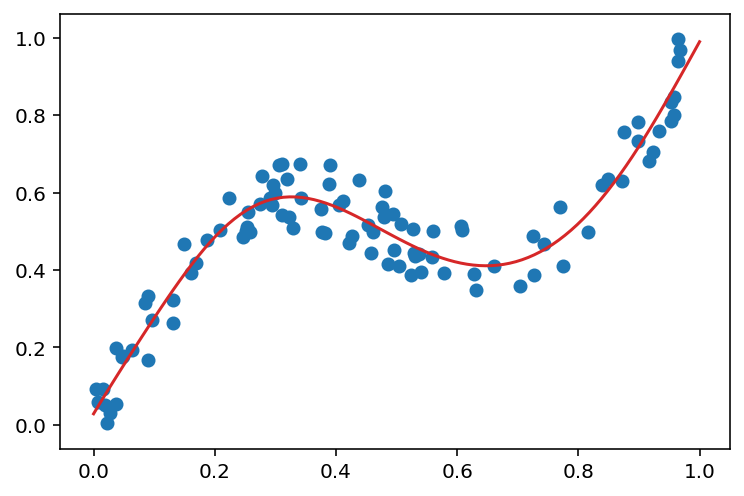

In [22]:
w0 = nnw.x
plt.scatter(X, tn)
plt.plot(xrange, fforward(w0, xrange.reshape(-1, 1)), c="tab:red")

## The Mixture Density Network

The loss function for the mixture density network is given by

$$
    E({\bf w}) = - \sum_{n=1}^N \ln\left\{\sum_{k=1}^K \pi_k({\bf x}_n, {\bf w})\mathcal{N}({\bf t}_n|{\boldsymbol \mu}_k({\bf x}, {\bf w}), {\bf I}\sigma_k^2
  ({\bf x}, {\bf w}))\right\}
$$

We will model the coeffients $\{\pi_k\}_k$, $\{{\boldsymbol \mu}_k\}_k$, and $\{\sigma_k\}_k$ as the outputs of a feed-forward neural network. In this example, we will consider three Gaussian components generated by a two-layer nnet with five `tanh` in each hidden layer and nine output units (three $\mu_k$s; three $\sigma_k$s; and three $\pi_k$s)

In [23]:
from scipy.stats import norm

In [60]:
def mixture(w, X, t):
    """
    Estimates the ouputs of a mixture density network
    """
    # Weights
    w1 = w[:nw1].reshape(ni, nh)
    w2 = w[nw1:nw2 + nw1].reshape(nh, nh)
    w3 = w[nw2 + nw1: nw3 + nw2 + nw1].reshape(nh, no)

    # biases
    wb1 = w[nw3 + nw2 + nw1: nb1 + nw3 + nw2 + nw1]
    wb2 = w[nb1 + nw3 + nw2 + nw1: nb2 + nb1 + nw3 + nw2 + nw1]
    wb3 = w[nb2 + nb1 + nw3 + nw2 + nw1: nb3 + nb2 + nb1 + nw3 + nw2 + nw1]
    
    coefs = np.tanh(np.tanh(X @ w1 + wb1) @ w2 + wb2) @ w3 + wb3
    a_pi = coefs[:, :3]
    a_mu = coefs[:, 3:6]
    a_sigma = coefs[:, 6:]

    pi = np.exp(a_pi) / np.exp(a_pi).sum(axis=1)[:, np.newaxis]
    mu = a_mu
    sigma = np.exp(a_sigma)

    return (pi * (1 / np.sqrt(2 * np.pi * sigma ** 2) *
            np.exp(- 1 / (2 * sigma ** 2) * (tn[:, np.newaxis] - mu) ** 2))).sum(axis=1)


def E(w, X, t):
    """
    Computes the negative log-likelihood error function for the
    mixture density nework.
    """
    return -np.log(mixture(w, X, t)).sum()

In [61]:
seed(271)
ni, nh, no = 1, 5, 9
nw1, nw2, nw3 = ni * nh, nh * nh, nh * no
nb1, nb2, nb3 = nh, nh, no

w = randn(ni * nh + nh * nh + nh * no + (nh + nh + no))

In [62]:
E(w, tn[:, np.newaxis], xn)

273.53812165135923

In [63]:
mixture(w, tn[:, np.newaxis], xn).shape

(100,)

In [64]:
nnw = minimize(E, w, (tn[:, np.newaxis], xn), method="l-bfgs-b",
               tol=1e-20)
nnw

      fun: -318.6267060304221
 hess_inv: <94x94 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 145.202, -126.911,  268.939, -174.494, -116.016,  352.054,
          6.504,   15.779, -174.461,  -78.375,  134.5  ,    0.351,
         61.719,  -37.404,   -0.426,   17.757,   -0.154,   14.317,
         -2.012,    2.555,   23.579,    1.19 ,  -18.697,  -22.066,
        -15.303, -402.264,   -7.384,  -14.038,  200.261,   88.694,
         -0.832,    1.748,   -0.916,   -0.227,   56.445, -458.777,
          0.626,  -14.169,    5.556,    0.234,   -6.075,    5.841,
         -0.223, -120.9  , -602.518,    0.9  ,   -1.079,   13.183,
         -0.829,    1.319,   -0.49 ,   -0.263,   56.052, -592.525,
          0.829,  -15.503,   11.336,    0.286,    1.916,   -2.202,
          0.174,   24.112,  377.464,   -0.557,    5.934,   -4.611,
         -1.171,    4.624,   -3.453,   -0.29 ,   88.436, -588.783,
          0.7  ,  -20.279,    6.909,  317.434, -168.099,  317.123,
       -229.646, -222.638, -44

In [66]:
np.set_printoptions(suppress=True, precision=3)

In [78]:
yn = mixture(nnw.x, tn[:, np.newaxis], xn)
yn

array([ 91.693,   0.124, 174.087,   7.238,   0.364,   7.569,  55.047,
       148.907, 193.558, 179.037,   0.004, 203.147,   7.645,   1.187,
        17.863, 114.177, 174.765,  11.491, 110.255, 140.108,  92.264,
        27.887,   3.708, 115.739,  90.169,   3.503,  82.151,   0.231,
        85.103, 106.319,   3.642,  55.472,   7.693, 117.34 ,  93.15 ,
        10.677,   0.005, 113.021,  93.377,  39.496, 118.725, 112.276,
        95.782,   0.158,   0.306,   0.005, 176.356, 108.13 ,  84.217,
        53.465,  83.861, 112.902,  41.053, 112.474,  87.943,   2.936,
        53.879,  96.072,  27.638,  93.084,  98.97 ,  12.304,  41.773,
       103.032, 106.438, 112.712,  91.281,   0.004,  91.767, 102.513,
         2.824, 176.817,  40.377,  53.145, 121.108,  71.921, 118.377,
       102.61 ,   4.004, 161.531, 118.417, 178.508,  55.613,  53.859,
        56.896, 175.967,  70.247, 105.758,  39.342,  39.228, 117.083,
         7.267, 101.845,  55.152,   0.005,  88.511,  91.619,   8.558,
         1.023,  22.

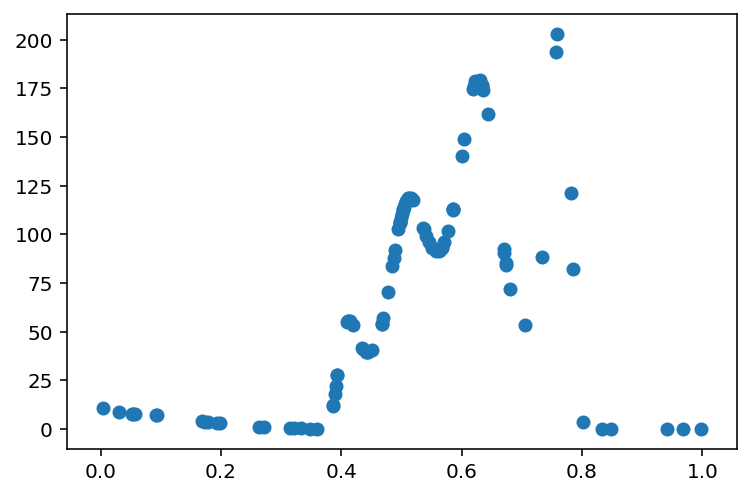

In [80]:
plt.scatter(tn, yn)